In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
!pip install xgboost

In [3]:
# Import required machine learning models and tools
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from xgboost import XGBClassifier


In [4]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,Internet,RoundTrip,27,6,9,Sat,PERPNH,Australia,1,0,1,5.62,0
49996,1,Internet,RoundTrip,111,6,4,Sun,PERPNH,Australia,0,0,0,5.62,0
49997,1,Internet,RoundTrip,24,6,22,Sat,PERPNH,Australia,0,0,1,5.62,0
49998,1,Internet,RoundTrip,15,6,11,Mon,PERPNH,Australia,1,0,1,5.62,0


In [5]:
df.shape

(50000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [7]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [8]:
# Feature Engineering
# Map categorical variable 'flight_day' to numerical values
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [9]:
print(df["flight_day"].unique())
print(df["sales_channel"].unique())
print(df["trip_type"].unique())
print(df["num_passengers"].unique())
print(df["booking_origin"].unique())

[6 3 4 1 7 2 5]
['Internet' 'Mobile']
['RoundTrip' 'CircleTrip' 'OneWay']
[2 1 3 4 6 5 7 9 8]
['New Zealand' 'India' 'United Kingdom' 'China' 'South Korea' 'Japan'
 'Malaysia' 'Singapore' 'Switzerland' 'Germany' 'Indonesia'
 'Czech Republic' 'Vietnam' 'Thailand' 'Spain' 'Romania' 'Ireland' 'Italy'
 'Slovakia' 'United Arab Emirates' 'Tonga' 'Réunion' '(not set)'
 'Saudi Arabia' 'Netherlands' 'Qatar' 'Hong Kong' 'Philippines'
 'Sri Lanka' 'France' 'Croatia' 'United States' 'Laos' 'Hungary'
 'Portugal' 'Cyprus' 'Australia' 'Cambodia' 'Poland' 'Belgium' 'Oman'
 'Bangladesh' 'Kazakhstan' 'Brazil' 'Turkey' 'Kenya' 'Taiwan' 'Brunei'
 'Chile' 'Bulgaria' 'Ukraine' 'Denmark' 'Colombia' 'Iran' 'Bahrain'
 'Solomon Islands' 'Slovenia' 'Mauritius' 'Nepal' 'Russia' 'Kuwait'
 'Mexico' 'Sweden' 'Austria' 'Lebanon' 'Jordan' 'Greece' 'Mongolia'
 'Canada' 'Tanzania' 'Peru' 'Timor-Leste' 'Argentina' 'New Caledonia'
 'Macau' 'Myanmar (Burma)' 'Norway' 'Panama' 'Bhutan' 'Norfolk Island'
 'Finland' 'Nicaragua

In [10]:
df.duplicated().sum()

719

In [11]:
df.drop_duplicates(inplace=True)

In [12]:
df.duplicated().sum()

0

In [13]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000,49281.000000
mean,1.590187,84.723281,23.053976,9.070676,3.813620,0.668229,0.295631,0.426635,7.279974,0.149977
std,1.016538,90.410229,33.832149,5.413099,1.991913,0.470854,0.456331,0.494593,1.496390,0.357052
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.000000,5.000000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.000000,9.000000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.000000,13.000000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.000000,23.000000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


In [14]:
df.corr(method='pearson')

/var/folders/vb/tz5cff5s6j3g60jvngcxycjh0000gn/T/ipykernel_1092/1928163937.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
num_passengers,1.000000,0.214999,-0.115380,0.016393,0.014801,0.120724,0.029509,0.022252,-0.062028,0.024092
purchase_lead,0.214999,1.000000,-0.076747,0.035112,0.036214,-0.021599,-0.004459,-0.022533,0.067934,-0.022132
length_of_stay,-0.115380,-0.076747,1.000000,-0.025525,0.000756,0.177536,0.031215,0.098846,0.140408,-0.042080
flight_hour,0.016393,0.035112,-0.025525,1.000000,0.024212,-0.010911,0.012251,0.011953,-0.003236,0.006705
flight_day,0.014801,0.036214,0.000756,0.024212,1.000000,-0.002517,0.005723,0.007799,0.019187,-0.007061
wants_extra_baggage,0.120724,-0.021599,0.177536,-0.010911,-0.002517,1.000000,0.208392,0.216835,0.057637,0.068452
wants_preferred_seat,0.029509,-0.004459,0.031215,0.012251,0.005723,0.208392,1.000000,0.315162,0.100652,0.050189
wants_in_flight_meals,0.022252,-0.022533,0.098846,0.011953,0.007799,0.216835,0.315162,1.000000,0.156233,0.026399
flight_duration,-0.062028,0.067934,0.140408,-0.003236,0.019187,0.057637,0.100652,0.156233,1.000000,-0.106529
booking_complete,0.024092,-0.022132,-0.042080,0.006705,-0.007061,0.068452,0.050189,0.026399,-0.106529,1.000000


In [15]:

df['route'].value_counts()

AKLKUL    2620
PENTPE     912
MELSGN     833
ICNSIN     793
DMKKIX     729
          ... 
AKLHGH       1
JEDPDG       1
JEDPEN       1
DACPEK       1
MRUXIY       1
Name: route, Length: 799, dtype: int64

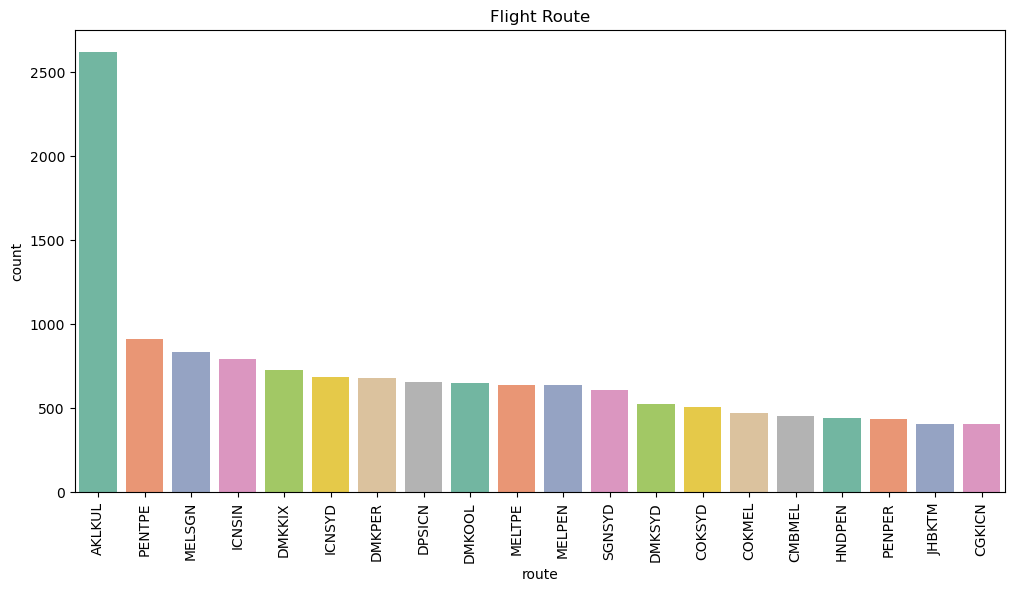

In [16]:
plt.figure(figsize=(12,6))
plt.title('Flight Route')
plt.xticks(rotation=90)
sns.countplot(x=df['route'].sort_index(), 
              data=df, 
              palette='Set2', 
              order=df.route.value_counts().iloc[:20].index,
              );

In [17]:
df['booking_origin'].value_counts().iloc[:20]

Australia         17691
Malaysia           7055
South Korea        4502
Japan              3819
China              3284
Indonesia          2317
Taiwan             2042
Thailand           1993
India              1258
New Zealand        1060
Singapore          1034
United States       453
Vietnam             386
Macau               301
Hong Kong           294
Philippines         265
United Kingdom      173
Brunei              161
Cambodia            131
(not set)            78
Name: booking_origin, dtype: int64

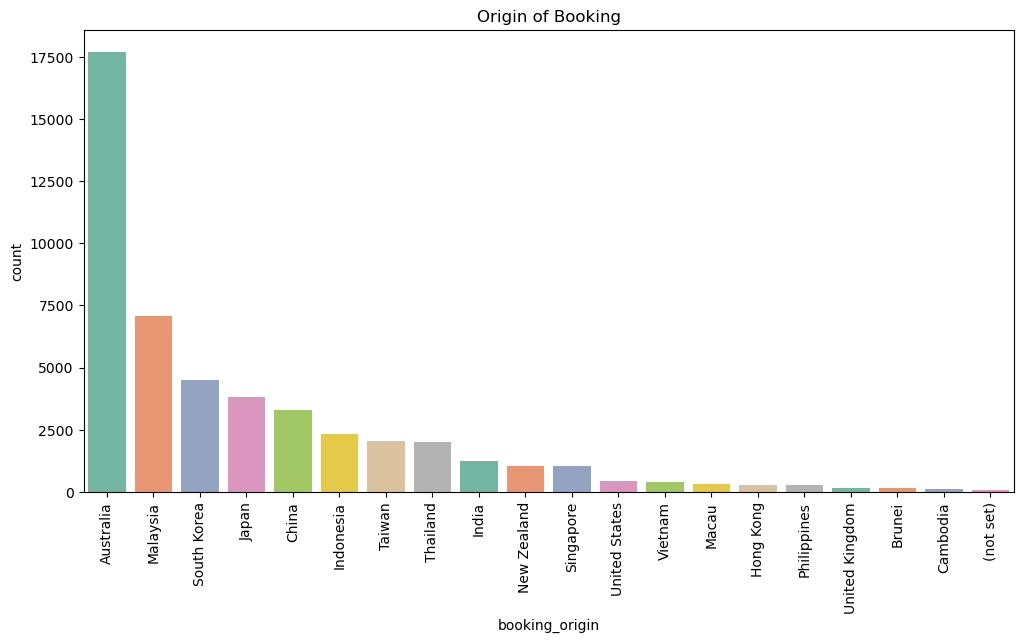

In [18]:
plt.figure(figsize=(12,6))
plt.title('Origin of Booking')
plt.xticks(rotation=90)
sns.countplot(x=df['booking_origin'].sort_index(), 
              data=df, 
              palette='Set2', 
              order=df.booking_origin.value_counts().iloc[:20].index,
              );

In [19]:
df['sales_channel'].value_counts(normalize=True)

Internet    0.891155
Mobile      0.108845
Name: sales_channel, dtype: float64

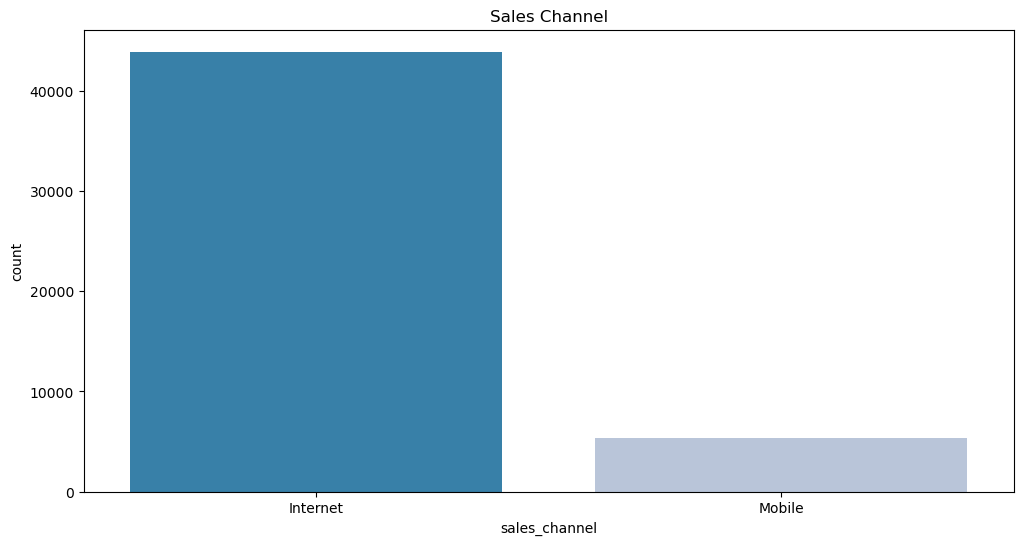

In [20]:
#sales_channel

plt.figure(figsize=(12,6))
plt.title("Sales Channel")
sns.countplot(x=df['sales_channel'], data=df, palette='PuBu_r');

In [21]:
df['trip_type'].value_counts(normalize=True)

RoundTrip     0.989814
OneWay        0.007833
CircleTrip    0.002354
Name: trip_type, dtype: float64

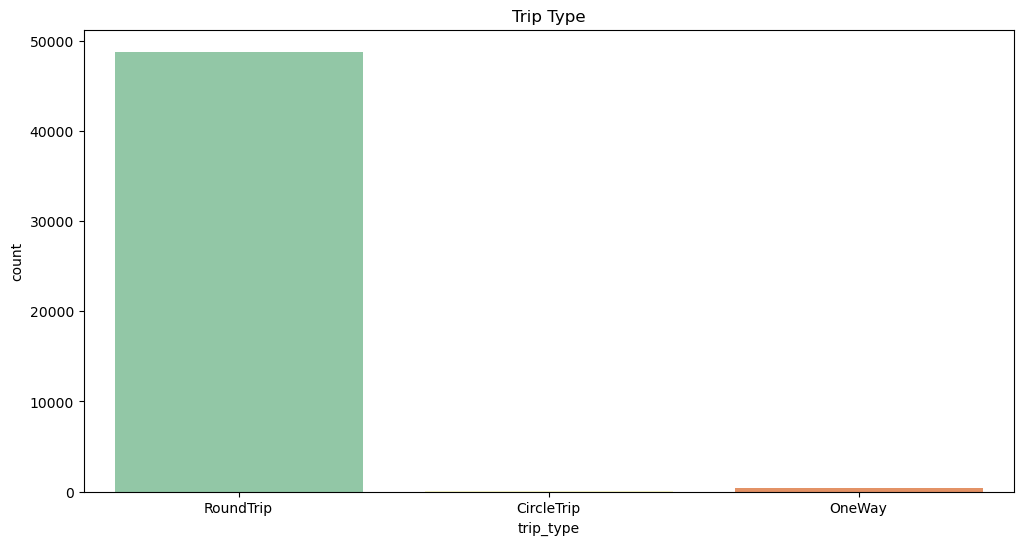

In [22]:
# Trip Type
plt.figure(figsize=(12,6))
plt.title("Trip Type")
sns.countplot(x=df['trip_type'], data=df, palette='Spectral_r');

In [23]:
df['num_passengers'].value_counts(normalize=True)

1    0.626590
2    0.257077
3    0.058481
4    0.035856
5    0.011039
6    0.005702
7    0.002171
8    0.001786
9    0.001299
Name: num_passengers, dtype: float64

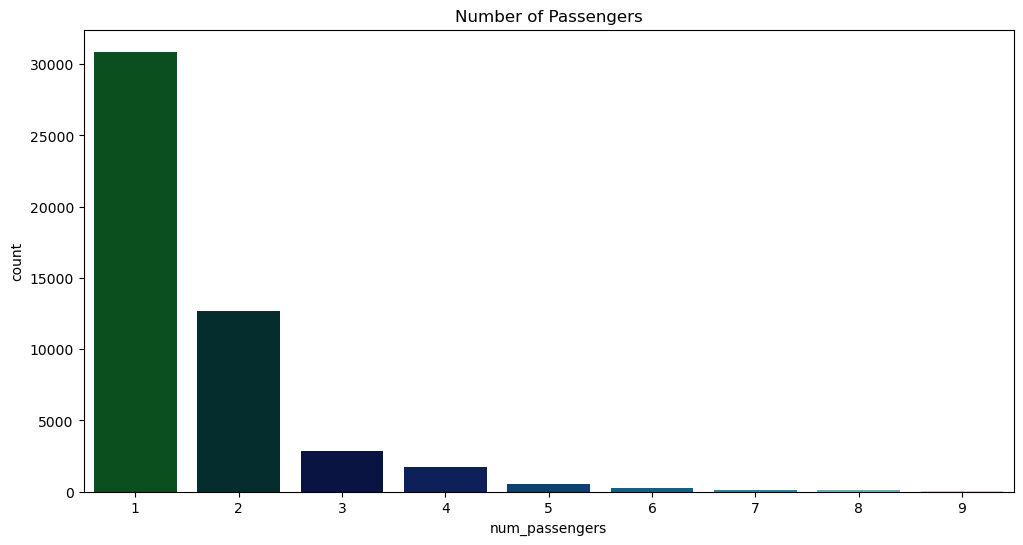

In [24]:
# num_passengers
plt.figure(figsize=(12,6))
plt.title('Number of Passengers')
sns.countplot(x=df['num_passengers'], data=df, palette='ocean');

In [25]:
df['wants_extra_baggage'].value_counts(normalize=True)

1    0.668229
0    0.331771
Name: wants_extra_baggage, dtype: float64

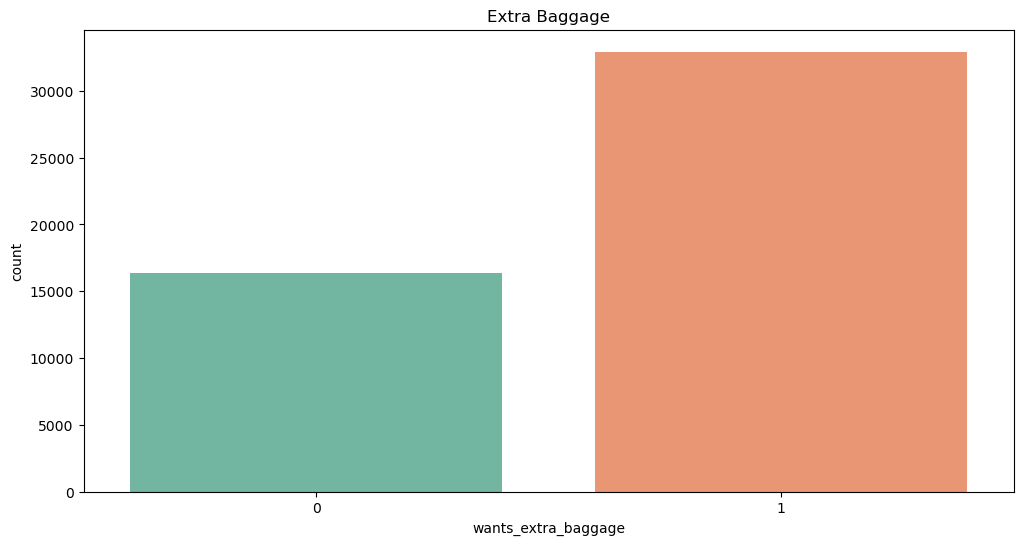

In [26]:
#wants_extra_baggage
plt.figure(figsize=(12,6))
plt.title('Extra Baggage')
sns.countplot(x=df['wants_extra_baggage'], data=df, palette='Set2');

In [27]:
df['wants_preferred_seat'].value_counts(normalize=True)

0    0.704369
1    0.295631
Name: wants_preferred_seat, dtype: float64

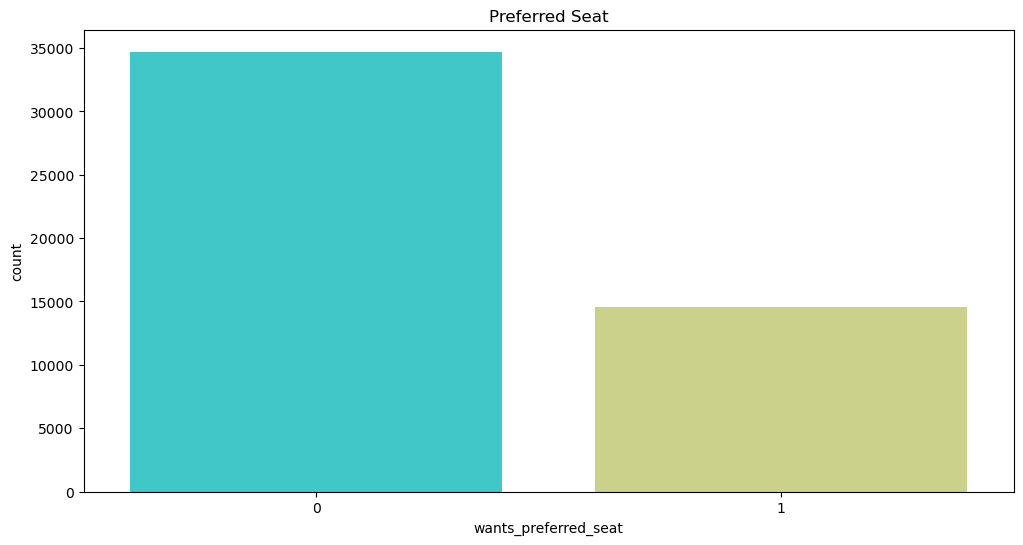

In [28]:
#wants_preferred_seat
plt.figure(figsize=(12,6))
plt.title('Preferred Seat')
sns.countplot(x=df['wants_preferred_seat'], data=df, palette='rainbow');

In [29]:
df['wants_in_flight_meals'].value_counts(normalize=True)

0    0.573365
1    0.426635
Name: wants_in_flight_meals, dtype: float64

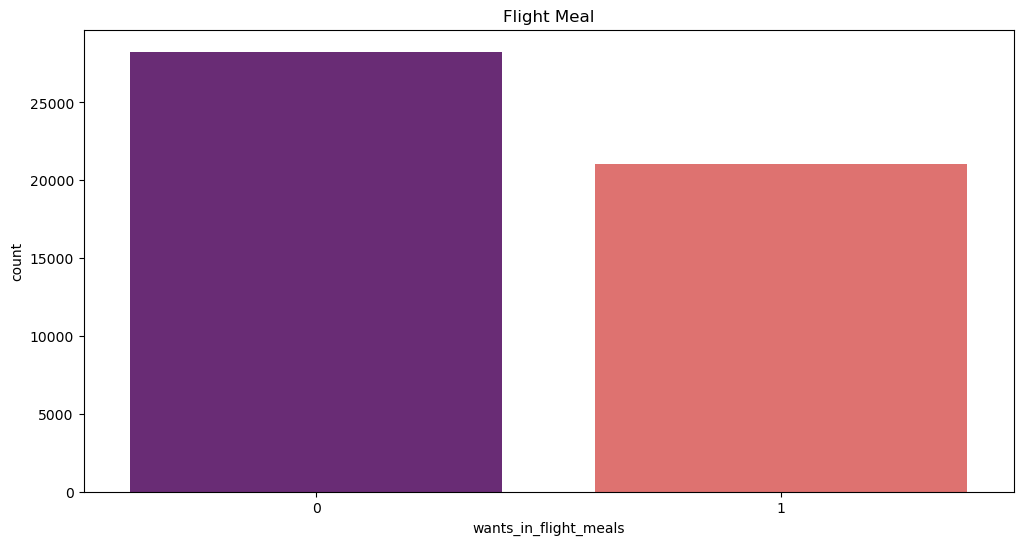

In [30]:
plt.figure(figsize=(12,6))
plt.title('Flight Meal')
sns.countplot(x=df['wants_in_flight_meals'], data=df, palette='magma');

In [31]:
df['booking_complete'].value_counts(normalize=True)

0    0.850023
1    0.149977
Name: booking_complete, dtype: float64

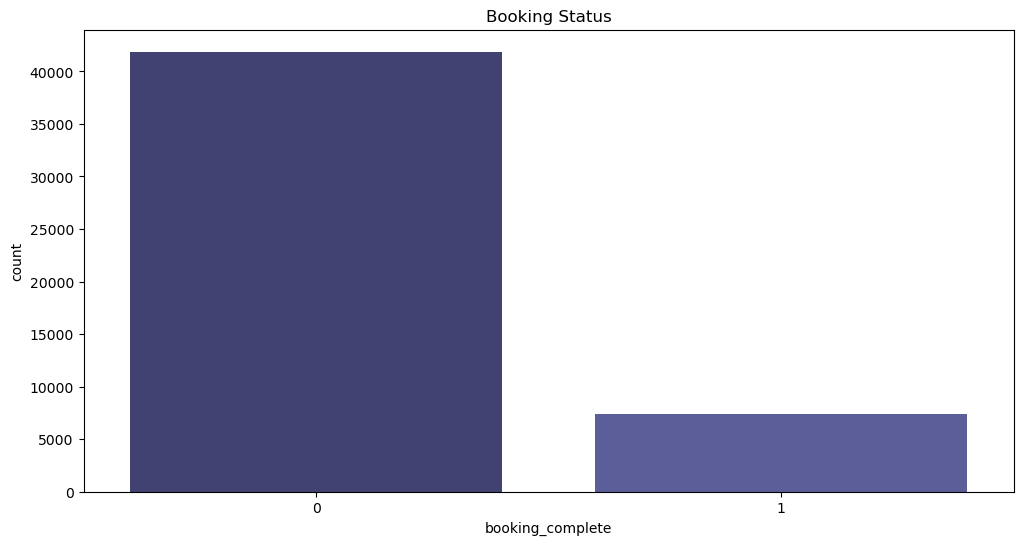

In [32]:
plt.figure(figsize=(12,6))
plt.title('Booking Status')
sns.countplot(x=df['booking_complete'], data=df, palette='tab20b');

Insights
1. The highest number of bookings is from Australia Origin.
2. Around 90% of bookings were done on the internet.
3. Around 67% of passengers wanted extra baggage in the booking.
4. Around 70% of customers do not want their preferred seat.
5. Around 57% of customers do not prefer meals.
6. Around 99% of passengers take Round Trips.
7. Around 62% of passengers are single travelers.
8. Around 85% of customers do not complete their booking.

In [33]:
# Standardize numerical features
scaler = StandardScaler()
numerical_columns = ['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour', 'flight_day', 'flight_duration']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [34]:
categorical_columns = ['sales_channel', 'trip_type', 'route', 'booking_origin']
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(df[categorical_columns])
encoded_columns = pd.DataFrame(encoded_columns.toarray(), columns=encoder.get_feature_names_out(categorical_columns))

In [35]:
# Concatenate the encoded columns with the original DataFrame
df_encoded = pd.concat([df, encoded_columns], axis=1)
# Drop the original categorical columns
df.drop(categorical_columns, axis=1, inplace=True)

In [36]:
# Train-test split
X = df.drop('booking_complete', axis=1)
y = df['booking_complete']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
# Model training and evaluation
def prediction(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    print(f"Train Accuracy: {model.score(X_train, y_train)}")
    print(f"Test Accuracy: {model.score(X_test, y_test)}")
    pred = model.predict(X_test)
    print(classification_report(y_test, pred))
    return model


In [38]:
# Random Forest Classifier
print("Random Forest Classifier:")
rf_model = prediction(RandomForestClassifier(), X_train, y_train, X_test, y_test)

Random Forest Classifier:
Train Accuracy: 0.9995434253246753
Test Accuracy: 0.8443745561529877
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      8378
           1       0.36      0.05      0.08      1479

    accuracy                           0.84      9857
   macro avg       0.61      0.52      0.50      9857
weighted avg       0.78      0.84      0.79      9857



In [39]:
# Gradient Boosting Classifier
print("Gradient Boosting Classifier:")
gb_model = prediction(GradientBoostingClassifier(), X_train, y_train, X_test, y_test)


Gradient Boosting Classifier:
Train Accuracy: 0.8503703327922078
Test Accuracy: 0.8499543471644516
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8378
           1       0.50      0.00      0.00      1479

    accuracy                           0.85      9857
   macro avg       0.68      0.50      0.46      9857
weighted avg       0.80      0.85      0.78      9857



In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression

model = BaggingClassifier(estimator=LogisticRegression(), n_estimators=50)
prediction(model, X_train, y_train, X_test, y_test)



Train Accuracy: 0.8500405844155844
Test Accuracy: 0.8499543471644516
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8378
           1       0.00      0.00      0.00      1479

    accuracy                           0.85      9857
   macro avg       0.42      0.50      0.46      9857
weighted avg       0.72      0.85      0.78      9857



/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


BaggingClassifier(estimator=LogisticRegression(), n_estimators=50)

In [41]:
from sklearn.model_selection import KFold, cross_val_score

In [42]:
# Cross-validation
print("Cross-validation with Random Forest Classifier:")
kfold = KFold(n_splits=10)
rf_cv_results = cross_val_score(rf_model, X, y, cv=kfold)
print("Mean Accuracy:", rf_cv_results.mean())

Cross-validation with Random Forest Classifier:
Mean Accuracy: 0.8426167981440349


In [43]:
# Hyperparameter tuning with GridSearchCV
print("Hyperparameter tuning with GridSearchCV for Gradient Boosting Classifier:")
params = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

Hyperparameter tuning with GridSearchCV for Gradient Boosting Classifier:


In [44]:
grid = GridSearchCV(GradientBoostingClassifier(), params, verbose=1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
best_gb_model = prediction(grid.best_estimator_, X_train, y_train, X_test, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Train Accuracy: 0.8501420454545454
Test Accuracy: 0.8498528964187887
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8378
           1       0.00      0.00      0.00      1479

    accuracy                           0.85      9857
   macro avg       0.42      0.50      0.46      9857
weighted avg       0.72      0.85      0.78      9857



In [45]:
# XGBoost Classifier
print("XGBoost Classifier:")
xgb_model = prediction(XGBClassifier(), X_train, y_train, X_test, y_test)

XGBoost Classifier:
Train Accuracy: 0.8674411525974026
Test Accuracy: 0.8464035710662473
              precision    recall  f1-score   support

           0       0.85      0.99      0.92      8378
           1       0.36      0.03      0.06      1479

    accuracy                           0.85      9857
   macro avg       0.61      0.51      0.49      9857
weighted avg       0.78      0.85      0.79      9857



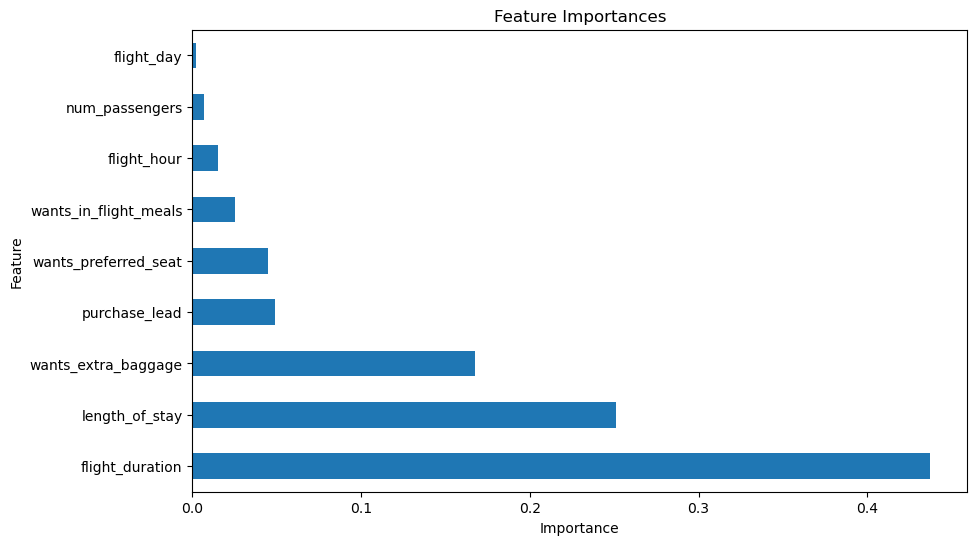

In [46]:
# Visualize Feature Importances for the best Gradient Boosting model
plt.figure(figsize=(10, 6))
feat_importances = pd.Series(best_gb_model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [49]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores # show a few features with their MI scores

flight_duration          0.016836
wants_extra_baggage      0.010794
length_of_stay           0.007500
num_passengers           0.004584
wants_in_flight_meals    0.004437
purchase_lead            0.003716
wants_preferred_seat     0.002712
flight_day               0.000409
flight_hour              0.000000
Name: MI Scores, dtype: float64

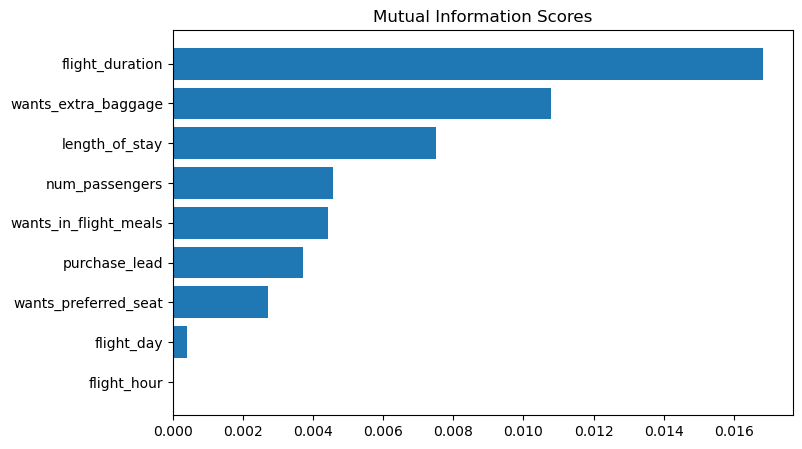

In [50]:

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
     